## Understanding Sentiment based on both Image Features and Text Information

### Read in trained ANP classifiers

In [1]:
import cPickle as pickle
import os
import re
import cv2
import numpy as np
import io
import ast
import hashlib
from scipy import sparse
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
%matplotlib inline


def get_files(path):
    """ Return a list of file names in this directory.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of file names, sorted alphabetically.
    """
    names = []
    for root, dirs, files in os.walk(path):
        for name in files:
            names.append(os.path.join(root, name))
    return names

def readDetectors(path):
    '''
    This is to read in all detectors saved in the folder
    path --- The folder where all detectors saved
    Return:
    a list of detectors.
    '''
    detectors = []
    files = sorted(get_files(path), key=lambda item: int(re.split("[_.]+", item)[-2]))
    for item in files:
        print item
        with open(item, 'rb') as fid:
            detectors.extend(pickle.load(fid))
    return detectors

def read(path):
    '''
    This is to read in classes each detectors trying to detect.
    '''
    with open(path, 'rb') as fid:
            labels = pickle.load(fid)
    return labels

detectors = readDetectors("detectors")
labels = read("labels.pkl")
codebook = read("my_dumped_codebook.pkl")
print len(detectors), len(labels), codebook.shape

detectors\classifier1_20.pkl
detectors\classifier21_30.pkl
detectors\classifier31_40.pkl
detectors\classifier41_50.pkl
detectors\classifier51_60.pkl
detectors\classifier61_70.pkl
detectors\classifier71_80.pkl
detectors\classifier81_100.pkl
detectors\classifier101_120.pkl
detectors\classifier121_130.pkl
detectors\classifier131_140.pkl
detectors\classifier141_160.pkl
detectors\classifier161_170.pkl
detectors\classifier171_180.pkl
detectors\classifier181_200.pkl
200 200 (646L, 128L)


### Read in collected dataset obtained through Flickr API

In [2]:
#Read in collected data.
def readText(data_path):
    string = io.open(data_path, encoding='utf8').readlines()
    info = [ast.literal_eval(item.strip()) for item in string if len(item)>1]
    return info

pos = readText("imageAndText"+os.sep+"Positive.txt")
neg = readText("imageAndText"+os.sep+"Negative.txt")
all_files = pos + neg
print "%d of positive photo text data" % (len(pos))
print "%d of negative photo text data" % (len(neg))
print "# of all data: %d" % len(all_files)
print "\nSample data format: "
print "image url: %s\ntitle: %s\n# of comments: %d\nDescription: %s\nin the %dth image of positive set." \
        %(pos[69][0], pos[69][1]['title'], len(pos[69][1]['comments']), pos[69][1]['description'], 70)

250 of positive photo text data
250 of negative photo text data
# of all data: 500

Sample data format: 
image url: https://farm6.staticflickr.com/5801/22768016020_d77cc96f68.jpg
title: Starz - Vero Beach, Florida
# of comments: 16
Description: This is a twilight shot when I was out shooting for meteors. No, this is not some strange phenomenon that happened, just a little fun in post. Hope you enjoy.

<a href="http://www.rscottduncan.com" rel="nofollow">www.rscottduncan.com</a>

<a href="http://www.facebook.com/RScottDuncanPhotography" rel="nofollow">www.facebook.com/RScottDuncanPhotography</a>
in the 70th image of positive set.


### Extract Features of image and then conduct content based detection

In [3]:
#This is to extrct surf descriptor for a given set of images.
#Code from BagOfVisualWords.py.
def featureExtract(filenames, hessianT=500):
    features = []
    noneFeatures = []
    for name in filenames:
        if os.path.getsize(name) > 3000:
            img = cv2.imread(name)
            surf = cv2.SURF(hessianT)
            if len(img.shape) > 2:
                gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            kp, des = surf.detectAndCompute(gray,None)
            if des is not None:
                features.append(des)
            else:
                noneFeatures.append(name)
                os.remove(name)
    return np.vstack(tuple(features)), features, noneFeatures

#Code from BagOfVisualWords.py
def quantization(features, codebook, t=0.7):
    '''
    Input
    features --- a list of surf descriptors for each image in dataset
    codebook --- visual vocabulary
    t --- a threshold control if a match should be included.
    Output
    an ndarray matrix. Each row represents an image. 
                        Each column is a visual word.
                        An entry in the matrix is the frequency of such visual words in an image.
    '''
    FLANN_INDEX_KDTREE = 0
    k=0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    flann = cv2.FlannBasedMatcher(index_params, {})
    result = np.zeros((len(features), len(codebook)), dtype=int)
    
    for feature in features:
        matches = flann.knnMatch(feature, codebook, k=2)
        for i,(m,n) in enumerate(matches):
            if m.distance < t*n.distance:
                result[k, m.trainIdx] += 1
        k += 1
        
    return result

def predict_class(image_path, codebook, labels, detectors, numOfResult=2):
    '''
    This function is to predict possibile content using classifiers and sort 
    classification result as per the probability of successful detection. We
    choose numOfResult amount of result that has the biggest probabilities.
    Return:
    a list of tuple---[(content, probability)]
    '''
    probs = []
    prediction = []
    result = []
    features = featureExtract(image_path)
    X = quantization(features[1],codebook,t=1)
    for i in range(0,len(detectors)):
        probs.append(tuple(detectors[i].predict_proba(X)[0])) 
    probs = sorted(enumerate(probs), key=lambda x:x[1][0], reverse=True)[:numOfResult]
    for item in probs:
        result.append((labels[item[0]], item[1][0]))
    return result

predict_class(["imageAndText\\image\\neg\\79.jpg"], codebook, labels, detectors, 5)

[('bright_lights', 0.99957756901808403),
 ('beautiful_clouds', 0.99928375800301705),
 ('ancient_city', 0.99922900419274685),
 ('awesome_night', 0.99920586285646595),
 ('awesome_clouds', 0.99865898421080568)]

##   Processing obtained text and different approaches is defined for fine-tuning

In [4]:
def extractText(text):
    soup = BeautifulSoup(text, "lxml")
    return soup.get_text()

def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    text = text.lower()
    token = re.sub("\W+", ' ', text).split()
    return token

def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    text = text.lower()
    text =re.sub('[\x85]', " ", text)
    return re.findall("\w+|[^\w\s]", text)

def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    tokens = tokenize_with_punct(text)
    for i in range(0, len(tokens)):
        if tokens[i] == "not":
            if i+1 in range(0, len(tokens)):
                tokens[i+1] = "%s%s" % ("not_", tokens[i+1])
            if i+2 in range(0, len(tokens)):
                tokens[i+2] = "%s%s" % ("not_", tokens[i+2])
    return tokens

def appendANPs(anps, text):
    '''
    append anps to the end of the whole string
    '''
    string = ""
    for anp in anps:
        string += anp[0].replace("_", " ")+" "
    return text+" "+string


###   Merge image information and text and then convert a list of files into a sparse csr_matrix

In [5]:
def mergeText(files):
    all_text = []
    for item in files:
        text = ""
        if len(item[1]['title']) > 0:
            text += extractText(item[1]['title'])+"\t"
        if len(item[1]['description']) > 0:
            text += extractText(item[1]['description'])+"\t"
        if len(item[1]['comments']) > 0:
            for comment in item[1]['comments']:
                text += extractText(comment)+"\t"
        all_text.append(text)
    return all_text

data = mergeText(all_files)
print "size of data:", len(data)
print "sample merged data:\n", data[-5:]

size of data: 500
sample merged data:
[u'Skid Row Cleanup\t', u'Skid Row Cleanup\t', u'Skid Row Cleanup\t', u'Skid Row Cleanup\t', u'Skid Row Cleanup\t']


In [6]:
def mergeANPs(data, codebook=codebook, labels=labels, \
              detectors=detectors, numOfResult=2, path = "imageAndText"+os.sep+"image"):
    result = []
    num = len(data)/2
    if numOfResult == 0:
        return data
    for i in range(len(data)):
        tag=""
        if i < num:
            tag="pos"
        else:
            tag="neg"
        anps = predict_class([path+os.sep+tag+os.sep+str(i%num)+".jpg"], \
                             codebook, labels, detectors, numOfResult)
        string = appendANPs(anps, data[i])
        result.append(string)
    return result

full_data = mergeANPs(data)

In [7]:
# This code is cited from asg3. a small change in input data format.
def do_vectorize(data, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        data.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    vectorizer = CountVectorizer(input='string', tokenizer = tokenizer_fn, \
                                 min_df = min_df, max_df = max_df, binary = binary,\
                                 ngram_range = ngram_range)
    
    return vectorizer.fit_transform(data).astype(int), vectorizer

matrix, vec = do_vectorize(full_data)
print ('matrix represents %d photos with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 500 photos with 5266 features
first doc has terms:
[13, 14, 145, 162, 191, 211, 225, 245, 272, 304, 313, 320, 322, 331, 351, 360, 362, 370, 397, 439, 444, 461, 463, 466, 468, 484, 490, 547, 555, 562, 570, 576, 579, 580, 605, 630, 633, 634, 647, 649, 652, 657, 658, 660, 662, 677, 683, 711, 716, 717, 729, 738, 755, 774, 849, 864, 909, 912, 916, 929, 961, 968, 971, 972, 983, 994, 998, 1015, 1019, 1039, 1077, 1080, 1087, 1157, 1167, 1184, 1205, 1219, 1221, 1223, 1229, 1243, 1250, 1359, 1387, 1396, 1411, 1433, 1434, 1450, 1451, 1454, 1481, 1484, 1496, 1519, 1522, 1541, 1544, 1545, 1547, 1567, 1576, 1613, 1629, 1638, 1645, 1685, 1695, 1727, 1746, 1764, 1789, 1798, 1801, 1816, 1828, 1829, 1866, 1868, 1870, 1874, 1899, 1921, 1964, 1988, 2006, 2014, 2023, 2033, 2035, 2039, 2051, 2054, 2058, 2059, 2095, 2096, 2099, 2111, 2128, 2129, 2131, 2167, 2184, 2209, 2220, 2225, 2251, 2270, 2272, 2283, 2304, 2305, 2315, 2347, 2351, 2380, 2403, 2415, 2417, 2458, 2522, 2534, 2543, 2546, 254

###   Shuffle data and complete experiement model

In [8]:
# This code is cited from asg3.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices]

y = np.array([1]*250 + [0]*250)
X, y= repeatable_shuffle(matrix, y)
print('First shuffled document has label %d and terms: %s' % 
      (y[0], sorted(X[0].nonzero()[1])))

First shuffled document has label 1 and terms: [22, 166, 254, 285, 286, 468, 490, 636, 697, 874, 1071, 1137, 1180, 1219, 1734, 1881, 2028, 2199, 2404, 2668, 2669, 2670, 2671, 2879, 3066, 3362, 3383, 3400, 3629, 3704, 4013, 4061, 4660, 4864, 4932, 4987, 5210]


In [103]:
def get_clf(c=1.0):
    return LogisticRegression(random_state=42, C=c)

def do_cross_validation(X, y, n_folds=5, verbose=False, method=get_clf, c=1.0, alpha=-1):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    kf = KFold(X.shape[0], n_folds)
    total = 0
    i = 0
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if c == 0:
            if alpha != -1:
                model = method(alpha=alpha)
            else:
                model = method()
        else:
            model = method(c=c)
        model = model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        if verbose:
            print "fold %d accuracy=%.4f" % (i, accuracy)
        total += accuracy
        i += 1
    return total/n_folds
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.8300
fold 1 accuracy=0.8500
fold 2 accuracy=0.8800
fold 3 accuracy=0.8400
fold 4 accuracy=0.8900
average cross validation accuracy=0.8580


In [87]:
#This is almost the same as that in asg3 except that I add a new tuning parameter.
def do_expt(data, tokenizer_fn=tokenize, codebook=codebook, \
            labels=labels, detectors=detectors, merged=True,
            method=get_clf, min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), c=1.0, alpha=-1, n_folds=5, numOfANPs=2):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        data.......list of strings, without adding any anps
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    if not merged and numOfANPs != 0:
        data = mergeANPs(data, codebook, labels, detectors, numOfResult=numOfANPs)
    labels = np.array([1]*250 + [0]*250)
    matrix, vec = do_vectorize(data, tokenizer_fn, min_df,\
                               max_df, binary, ngram_range)
    X, y= repeatable_shuffle(matrix, labels)
    return do_cross_validation(X, y, n_folds, method=method, c=c, alpha=alpha)

### Compare accuracy of various parameter settings

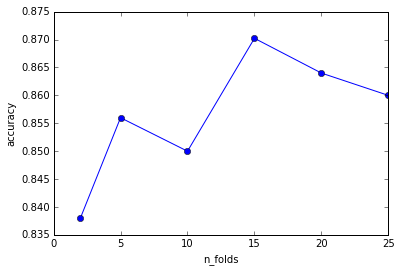

[0.83799999999999997,
 0.85599999999999987,
 0.84999999999999998,
 0.87023172905525825,
 0.86400000000000021,
 0.85999999999999988]

In [74]:
def compare_n_folds(full_data, method=get_clf, binary=True, c=1.0):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    accuracies = [do_expt(data, n_folds=i, binary=binary, method=method, c=c) for i in [2, 5, 10, 15, 20, 25]]
    plt.plot([2, 5, 10, 15, 20, 25], accuracies, 'bo-')
    plt.ylabel('accuracy')
    plt.xlabel('n_folds')
    plt.show()
    return accuracies
    
compare_n_folds(full_data)

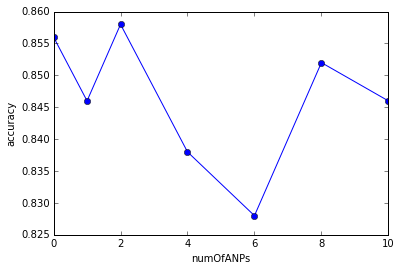

[0.85599999999999987,
 0.84599999999999986,
 0.85799999999999998,
 0.83800000000000008,
 0.82799999999999996,
 0.85199999999999998,
 0.84600000000000009]

In [179]:
#This part is to compare different ANPs we include in each vector.

def compare_n_ANPs(data, binary=True, method=get_clf, c=1.0):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    accuracies = [do_expt(data, binary=binary, \
                          merged=False, numOfANPs=i, method=method, c=c) for i in [0, 1, 2, 4, 6, 8, 10]]
    plt.plot([0, 1, 2, 4, 6, 8, 10], accuracies, 'bo-')
    plt.ylabel('accuracy')
    plt.xlabel('numOfANPs')
    plt.show()
    return accuracies
    
compare_n_ANPs(data)

In [75]:
def compare_binary(full_data, method=get_clf, c=1.0):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    return [do_expt(full_data, method=method, c=c), do_expt(full_data, method=method, binary=False, c=c)]
          
compare_binary(full_data)

[0.85799999999999998, 0.85799999999999998]

#### From experiment above, there seems to be no difference.

In [76]:
def tokenizer_expt(full_data, binary=True, method=get_clf, c=1.0):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    return [do_expt(full_data, binary=binary, method=method, c=c), do_expt(full_data, binary=binary, method=method,\
                                                 tokenizer_fn = tokenize_with_punct, c=c),\
            do_expt(full_data, method=method, binary=binary, tokenizer_fn = tokenize_with_not, c=c)]

tokenizer_expt(full_data)

[0.85799999999999998, 0.86799999999999999, 0.86599999999999999]

#### This indicates that tokenize with punct contribute to a small increment in accuracy

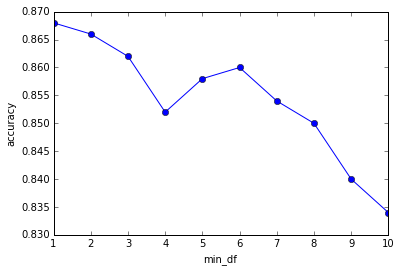

[0.86799999999999999,
 0.86599999999999999,
 0.86199999999999988,
 0.85199999999999998,
 0.85799999999999998,
 0.85999999999999999,
 0.85399999999999987,
 0.84999999999999998,
 0.84000000000000008,
 0.83399999999999996]

In [81]:
def min_df_expt(full_data, binary=True, method=get_clf, c=1.0):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    accuracies = [do_expt(full_data, method=method, min_df=i, binary=binary, \
                          tokenizer_fn=tokenize_with_punct, c=c) for i in range(1, 11)]
    plt.plot(range(1, 11), accuracies, "bo-")
    plt.ylabel("accuracy")
    plt.xlabel("min_df")
    plt.show()
    return accuracies

min_df_expt(full_data)

#### We observe that min_df = 1 produces the best result

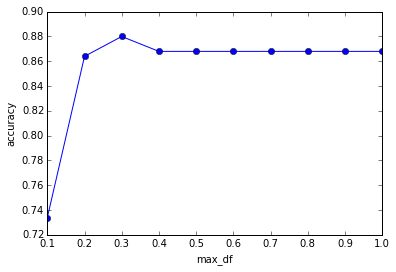

[0.73399999999999999,
 0.8640000000000001,
 0.88000000000000012,
 0.86799999999999999,
 0.86799999999999999,
 0.86799999999999999,
 0.86799999999999999,
 0.86799999999999999,
 0.86799999999999999,
 0.86799999999999999]

In [82]:
def max_df_expt(full_data, binary=True, method=get_clf, c=1.0):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    accuracies = [do_expt(full_data, method=method, binary=binary,\
                          min_df=1, max_df=i, tokenizer_fn=tokenize_with_punct, c=c)\
                  for i in np.arange(.1, 1.1, .1)]
    plt.plot(np.arange(.1, 1.1, .1), accuracies, "bo-")
    plt.ylabel("accuracy")
    plt.xlabel("max_df")
    plt.show()
    return accuracies
    
max_df_expt(full_data)

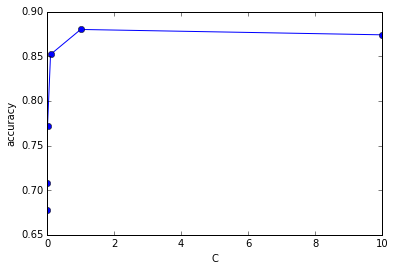

[0.67800000000000005,
 0.70799999999999996,
 0.77200000000000002,
 0.85199999999999998,
 0.88000000000000012,
 0.874]

In [49]:
def c_expt(full_data, binary=True, method=get_clf):
    
    accuracies = [do_expt(full_data, method=method, binary=binary,\
                          min_df=1, max_df=0.3, c=i, tokenizer_fn=tokenize_with_punct)\
                  for i in [0.0001, 0.001, 0.01, 0.1, 1, 10]]
    plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10], accuracies, "bo-")
    plt.ylabel("accuracy")
    plt.xlabel("C")
    plt.show()
    return accuracies

c_expt(full_data)

#### Based on above fine-tuning experiments, we set:
1. binary=True
2. tokenizer_fn=tokenize_with_punct
3. min_df=1
4. max_df=0.3
5. numofANPs=2
6. C=1.0

#### Result in 5-fold cross validation accuracy: 0.880

In [65]:
#Final classifier based on settings above.
matrix, vec = do_vectorize(full_data, binary=True, \
                           tokenizer_fn=tokenize_with_punct, min_df=2, max_df=0.7)
clf = get_clf(c=10)
test_X, test_Y= repeatable_shuffle(matrix, np.array([1]*250+[0]*250))
clf.fit(test_X, test_Y)
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1L, 2375L)


In [67]:
#This function is cited from asg3 
def get_top_coefficients(clf, vec, n=10):
    """ Get the top n coefficients for each class (positive/negative).
    Params:
        clf...a LogisticRegression object that has already been fit to data.
        vec...a CountVectorizer
        n.....the number of features to print per class.
    Returns:
        Two lists of tuples. The first list containts the top terms for the positive
        class. Each entry is a tuple of (string, float) pairs, where
        string is the feature name and float is the coefficient.
        The second list is the same but for the negative class.
        In each list, entries should be sorted in descending order of 
        absolute value."""
    data = zip(vec.get_feature_names(), clf.coef_[0])
    data = sorted(data, key=lambda tup: tup[1], reverse=True)
    return data[:n], data[:-(n+1):-1]
    

pos_coef, neg_coef = get_top_coefficients(clf, vec, n=10)
print('top positive coefs: %s' % str(pos_coef))
print('top negative coefs: %s' % str(neg_coef))

top positive coefs: [(u'boston', 3.2956948605191023), (u'view', 3.1631143653401192), (u'halloween', 2.5643067964159605), (u'fallminishoot', 2.3285228761213559), (u'happy', 2.0852203362530517), (u'love', 1.5775700089239437), (u'brooklyn', 1.4287346293028695), (u'behind', 1.4174709884640162), (u'30', 1.3718295204677593), (u'|', 1.2944505987126067)]
top negative coefs: [(u'homeless', -2.6527157383190243), (u'mistakes', -2.3200168833918742), (u'skid', -2.2340265018319694), (u'row', -2.2339474952892497), (u'cleanup', -2.1072745427168935), (u'house', -1.7553102541495378), (u'poor', -1.6971746434571835), (u'capital', -1.6942275343025348), (u'to', -1.6744385575571867), (u'this', -1.6655327588007527)]


### Test Model on Test Dataset

In [18]:
test_pos = readText("testData"+os.sep+"Positive.txt")
test_neg = readText("testData"+os.sep+"Negative.txt")
test_all_files = test_pos+test_neg

print "%d of positive photo text data" % (len(test_pos))
print "%d of negative photo text data" % (len(test_neg))
print "# of all data: %d" % len(test_all_files)
print "\nSample data format: "
print "image url: %s\ntitle: %s\n# of comments: %d\nDescription: %s\nin the %dth image of negative set." \
        %(test_neg[4][0], test_neg[4][1]['title'], len(test_neg[4][1]['comments']), test_neg[4][1]['description'], 4+1)

100 of positive photo text data
100 of negative photo text data
# of all data: 200

Sample data format: 
image url: https://farm6.staticflickr.com/5760/22596200079_774a4ca8a8.jpg
title: 
# of comments: 2
Description: <a href="http://www.patrickjoust.com/" rel="nofollow">patrickjoust</a> | <a href="https://www.flickr.com/photos/patrickjoust/">flickr</a> | <a href="http://patrickjoust.tumblr.com/" rel="nofollow">tumblr</a> | <a href="https://www.facebook.com/pages/Patrick-Joust-Photography/645241562187391" rel="nofollow">facebook</a> | <a href="http://www.magcloud.com/user/patrickjoust" rel="nofollow">books</a>

...

Fujica GW690

Kodak Portra 160
in the 5th image of negative set.


In [19]:
test_data = mergeText(test_all_files)
test_full_data = mergeANPs(test_data, path = "testData"+os.sep+"image")

In [66]:
Y_test = np.array([1]*100 + [0]*100)
X_test = vec.transform(test_full_data)

print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(Y_test==1)[0]),
                                                          len(np.where(Y_test==0)[0])))
print('testing accuracy=%.4g' % accuracy_score(Y_test, clf.predict(X_test)))

X_test represents 200 documents with 2375 features
y_test has 100 positive and 100 negative labels
testing accuracy=0.675


#### Above experiment indicates that such model performs bad(0.880 to 0.675) when predicting new descriptions and images. Our model is severely over-fitted. The possible reason is that training set we collected is not big enough, thus it cannot comprehensively represent population. 


### Training with Multinomial Niave Bayes

In [95]:
def get_mnb(alpha=1.0):
    return MultinomialNB(alpha=alpha)

print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, method=get_mnb, verbose=True, c=0))

fold 0 accuracy=0.8700
fold 1 accuracy=0.7500
fold 2 accuracy=0.8000
fold 3 accuracy=0.7800
fold 4 accuracy=0.7600
average cross validation accuracy=0.7920


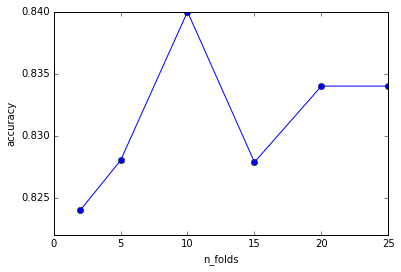

[0.82399999999999995,
 0.82799999999999996,
 0.84000000000000008,
 0.82786690433749244,
 0.83399999999999996,
 0.83400000000000007]

In [104]:
compare_n_folds(full_data, binary=True, method=get_mnb, c=0)

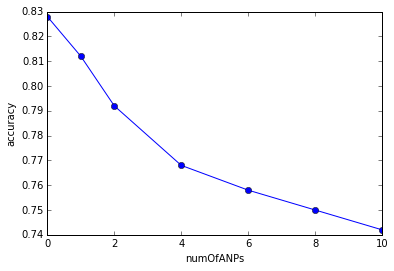

[0.82799999999999996,
 0.81200000000000006,
 0.79200000000000004,
 0.76800000000000002,
 0.7579999999999999,
 0.75,
 0.74199999999999999]

In [180]:
compare_n_ANPs(data, method=get_mnb, c=0)

ANPs = 0

In [105]:
compare_binary(data, method=get_mnb, c=0)

[0.82799999999999996, 0.7380000000000001]

binary=True

In [112]:
tokenizer_expt(data, method=get_mnb, c=0)

[0.82799999999999996, 0.82800000000000007, 0.82800000000000007]

tokenize_fn = with_punct

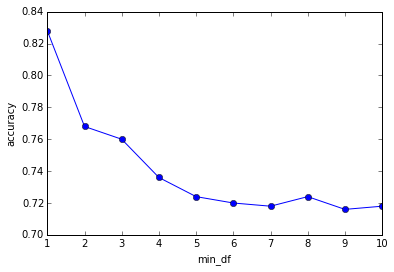

[0.82800000000000007,
 0.76800000000000002,
 0.76000000000000001,
 0.73599999999999999,
 0.72399999999999998,
 0.71999999999999997,
 0.71799999999999997,
 0.72399999999999998,
 0.71599999999999997,
 0.71799999999999997]

In [113]:
min_df_expt(data, method=get_mnb, c=0)

min_df=1

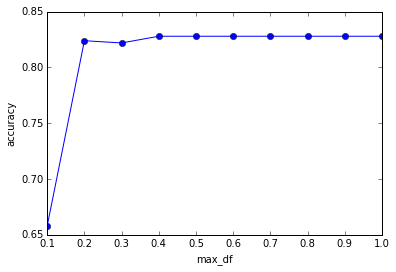

[0.65800000000000003,
 0.82400000000000007,
 0.82199999999999984,
 0.82800000000000007,
 0.82800000000000007,
 0.82800000000000007,
 0.82800000000000007,
 0.82800000000000007,
 0.82800000000000007,
 0.82800000000000007]

In [108]:
max_df_expt(data, method=get_mnb, c=0)

max_df=0.5

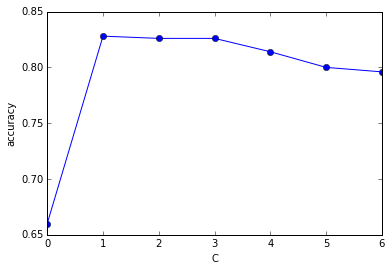

[0.65999999999999992,
 0.82800000000000007,
 0.82599999999999996,
 0.82599999999999996,
 0.81400000000000006,
 0.79999999999999993,
 0.79600000000000004]

In [115]:
def alpha_expt(data, binary=True, method=get_mnb, c=0):
    
    accuracies = [do_expt(data, method=method, binary=binary,\
                          min_df=1, max_df=0.5, c=0, alpha=i, tokenizer_fn=tokenize_with_punct)\
                  for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]]
    plt.plot([0, 1, 2, 3, 4, 5, 6], accuracies, "bo-")
    plt.ylabel("accuracy")
    plt.xlabel("C")
    plt.show()
    return accuracies

alpha_expt(data)

#### Alpha = 1

#### Overall performance of MNB on training set: 0.828

### Test MNB on testset

In [144]:
matrix_mnb, vec_mnb = do_vectorize(data, binary=True, \
                           tokenizer_fn=tokenize_with_punct, min_df=3, max_df=0.5)
mnb = get_mnb()
test_X_mnb, test_Y_mnb= repeatable_shuffle(matrix_mnb, np.array([1]*250+[0]*250))
mnb.fit(test_X_mnb, test_Y_mnb)
print mnb.coef_.shape

(1L, 1656L)


In [145]:
Y_test_mnb = np.array([1]*100 + [0]*100)
X_test_mnb = vec_mnb.transform(test_data)

print('X_test represents %d documents with %d features' % (X_test_mnb.shape[0], X_test_mnb.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(Y_test_mnb==1)[0]),
                                                          len(np.where(Y_test_mnb==0)[0])))
print('testing accuracy=%.4g' % accuracy_score(Y_test_mnb, mnb.predict(X_test_mnb)))

X_test represents 200 documents with 1656 features
y_test has 100 positive and 100 negative labels
testing accuracy=0.82


### What if we use only features from images to classify?

#### First we need to train visual vocalulary for images in trainning set using bag of visual words model

In [147]:
#Code from BagOfVisualWorlds.py
def kmeans(data, k, maxIteration=10, accuracy=1.0, attempts=10):
    '''
    learning visual vocabulary for each ANP
    '''
    criteria = (cv2.TERM_CRITERIA_EPS + \
                cv2.TERM_CRITERIA_MAX_ITER, maxIteration, accuracy)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data, k, criteria, attempts, flags)
    return compactness,labels,centers

def findK(data):
    '''
    This is to estimate a possible # of clusters in a dataset.
    Also the size of the codebook.
    Initial k.
    Rule of thumb estimation.
    https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set
    '''
    return int((data.shape[0] / 2.0) ** 0.5+1)

def build_codebook(files):
    features = featureExtract(files)
    codebook = kmeans(features[0], findK(features[0]))
    return codebook[2]

def sort(files):
    return sorted(files, key=lambda x:int(x.split("\\")[-1].split(".")[0]))

image_files = sort(get_files("imageAndText"+os.sep+"image"+os.sep+"pos"))+\
                sort(get_files("imageAndText"+os.sep+"image"+os.sep+"neg"))
image_files[:5]

['imageAndText\\image\\pos\\0.jpg',
 'imageAndText\\image\\pos\\1.jpg',
 'imageAndText\\image\\pos\\2.jpg',
 'imageAndText\\image\\pos\\3.jpg',
 'imageAndText\\image\\pos\\4.jpg']

In [148]:
vocabulary = build_codebook(image_files)

In [149]:
print "We learned %d visual words from training set."% (vocabulary.shape[0])

We learned 442 visual words from training set.


#### Transform images into vetctors containning frequency of visual words

In [150]:
visual_data = quantization(featureExtract(image_files)[1], vocabulary)

In [151]:
visual_data = sparse.csr_matrix(visual_data)
print "Shape of the frequency matrix:", visual_data.shape

Shape of the frequency matrix: (500, 442)


#### Train classifier

In [152]:
image_labels = np.array([1]*250 + [0]*250)
image_X, image_Y= repeatable_shuffle(visual_data, image_labels)

In [153]:
clf_image = get_clf()
clf_image.fit(image_X, image_Y)

print type(clf_image.coef_)
print clf_image.coef_.shape
print "5-fold corss validation accuracy: ", do_cross_validation(image_X, image_Y, 5)

<type 'numpy.ndarray'>
(1L, 442L)
5-fold corss validation accuracy:  0.606


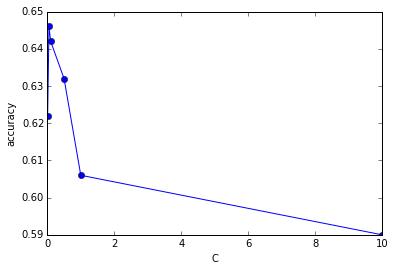

[0.622,
 0.64599999999999991,
 0.64200000000000002,
 0.63200000000000001,
 0.60599999999999998,
 0.59000000000000008]

In [158]:
def tune_c_image(image_X, image_Y):
    accuracies = [do_cross_validation(image_X, image_Y, n_folds=5, c=i)\
                  for i in [0.01, 0.05, 0.1, 0.15, 1, 10]]
    plt.plot([0.01, 0.05, 0.1, 0.5, 1, 10], accuracies, "bo-")
    plt.ylabel("accuracy")
    plt.xlabel("C")
    plt.show()
    return accuracies

tune_c_image(image_X, image_Y)

### C= 0.05 for LRL2

### accuracy in 5-fold CV: 0.646

#### The accuracy is far smaller than that of classification based on text

### Let us see how classifier purely based on images performs on test dataset

In [159]:
visual_test = sort(get_files("testData"+os.sep+"image"+os.sep+"pos"))+\
                sort(get_files("testData"+os.sep+"image"+os.sep+"neg"))
visual_test_data = quantization(featureExtract(visual_test)[1], vocabulary)

In [177]:
final_classifier = get_clf(c=10).fit(image_X, image_Y)

In [178]:
visual_test_label = np.array([1]*100+[0]*100)

print('X_test represents %d documents with %d features' % (visual_test_data.shape[0], visual_test_data.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(visual_test_label==1)[0]),
                                                          len(np.where(visual_test_label==0)[0])))
print('testing accuracy=%.4g' % accuracy_score(visual_test_label, final_classifier.predict(visual_test_data)))

X_test represents 200 documents with 442 features
y_test has 100 positive and 100 negative labels
testing accuracy=0.7


### **It performs not bad on the test set**

### Result

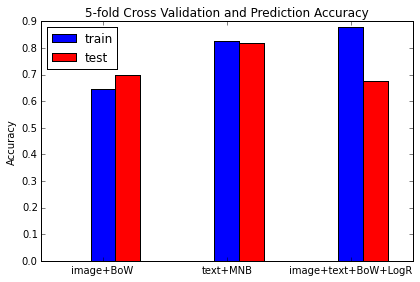

In [21]:
def result():
    fig, ax = plt.subplots()
    test = [0.7, 0.82, 0.675]
    train = [0.646, 0.828, 0.880]
    x = [0.4, 0.8, 1.2]
    models = ['image+BoW', 'text+MNB', 'image+text+BoW+LogR']
    ax.bar(np.arange(len(models)), train,width=0.2,color='b',align='center', label='train')
    ax.bar(np.arange(len(models))+0.2, test,width=0.2,color='r',align='center', label='test')
    plt.xticks(np.arange(len(models)), models)
    plt.ylabel('Accuracy')
    plt.title('5-fold Cross Validation and Prediction Accuracy')
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

result()